# LSTM Travel Time + Speed Prediction - Cent.4

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'Cent.4')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6389,77,33,2021042800
6403,77,33,2021042800
6417,77,33,2021042800
6431,77,33,2021042800
6445,77,33,2021042800
...,...,...,...
294414,77,33,2021051509
294428,77,33,2021051509
294442,77,33,2021051509
294456,77,33,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,77.000000,33.000000
2021042801,77.000000,33.000000
2021042802,67.137255,38.666667
2021042803,76.346154,33.346154
2021042804,77.000000,33.000000
...,...,...
2021051505,77.000000,33.000000
2021051506,77.000000,33.000000
2021051507,77.000000,33.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,0.603469
2021042803,0.973712
2021042804,1.000000
...,...
2021051505,1.000000
2021051506,1.000000
2021051507,1.000000


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

# LSTM - Time

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Adagrad', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 9s 1s/step - loss: 0.8910 - mae: 0.8683 - rmse: 0.8966 - val_loss: 0.8690 - val_mae: 0.8690 - val_rmse: 0.8690
Epoch 2/300
3/3 [==============================] - 0s 85ms/step - loss: 0.8120 - mae: 0.7890 - rmse: 0.8143 - val_loss: 0.7937 - val_mae: 0.7936 - val_rmse: 0.7937
Epoch 3/300
3/3 [==============================] - 0s 112ms/step - loss: 0.7523 - mae: 0.7321 - rmse: 0.7549 - val_loss: 0.7285 - val_mae: 0.7284 - val_rmse: 0.7285
Epoch 4/300
3/3 [==============================] - 0s 94ms/step - loss: 0.6848 - mae: 0.6656 - rmse: 0.6864 - val_loss: 0.6690 - val_mae: 0.6689 - val_rmse: 0.6690
Epoch 5/300
3/3 [==============================] - 0s 85ms/step - loss: 0.6519 - mae: 0.6337 - rmse: 0.6442 - val_loss: 0.6149 - val_mae: 0.6149 - val_rmse: 0.6149
Epoch 6/300
3/3 [==============================] - 0s 99ms/step - loss: 0.5979 - mae: 0.5829 - rmse: 0.6028 - val_loss: 0.5654 - val_mae: 0.5654 - val_rmse: 0.5654
Epoch 7/300
3/3 [

Epoch 51/300
3/3 [==============================] - 0s 59ms/step - loss: 0.1967 - mae: 0.1156 - rmse: 0.1817 - val_loss: 0.0575 - val_mae: 0.0571 - val_rmse: 0.0575
Epoch 52/300
3/3 [==============================] - 0s 60ms/step - loss: 0.1955 - mae: 0.1214 - rmse: 0.1813 - val_loss: 0.0561 - val_mae: 0.0557 - val_rmse: 0.0561
Epoch 53/300
3/3 [==============================] - 0s 66ms/step - loss: 0.2089 - mae: 0.1217 - rmse: 0.1948 - val_loss: 0.0546 - val_mae: 0.0542 - val_rmse: 0.0546
Epoch 54/300
3/3 [==============================] - 0s 67ms/step - loss: 0.1992 - mae: 0.1153 - rmse: 0.1808 - val_loss: 0.0538 - val_mae: 0.0534 - val_rmse: 0.0538
Epoch 55/300
3/3 [==============================] - 0s 64ms/step - loss: 0.2074 - mae: 0.1208 - rmse: 0.1973 - val_loss: 0.0523 - val_mae: 0.0519 - val_rmse: 0.0523
Epoch 56/300
3/3 [==============================] - 0s 62ms/step - loss: 0.2016 - mae: 0.1129 - rmse: 0.1854 - val_loss: 0.0513 - val_mae: 0.0509 - val_rmse: 0.0513
Epoch 57/3

Epoch 101/300
3/3 [==============================] - 0s 55ms/step - loss: 0.1964 - mae: 0.0892 - rmse: 0.1766 - val_loss: 0.0278 - val_mae: 0.0270 - val_rmse: 0.0278
Epoch 102/300
3/3 [==============================] - 0s 57ms/step - loss: 0.1963 - mae: 0.0949 - rmse: 0.1784 - val_loss: 0.0274 - val_mae: 0.0266 - val_rmse: 0.0274
Epoch 103/300
3/3 [==============================] - 0s 59ms/step - loss: 0.2012 - mae: 0.0944 - rmse: 0.1847 - val_loss: 0.0271 - val_mae: 0.0262 - val_rmse: 0.0271
Epoch 104/300
3/3 [==============================] - 0s 55ms/step - loss: 0.2007 - mae: 0.0965 - rmse: 0.1805 - val_loss: 0.0268 - val_mae: 0.0259 - val_rmse: 0.0268
Epoch 105/300
3/3 [==============================] - 0s 57ms/step - loss: 0.1991 - mae: 0.0912 - rmse: 0.1810 - val_loss: 0.0265 - val_mae: 0.0256 - val_rmse: 0.0265
Epoch 106/300
3/3 [==============================] - 0s 56ms/step - loss: 0.1985 - mae: 0.0930 - rmse: 0.1770 - val_loss: 0.0263 - val_mae: 0.0254 - val_rmse: 0.0263
Epoc

3/3 [==============================] - 0s 60ms/step - loss: 0.2039 - mae: 0.0898 - rmse: 0.1830 - val_loss: 0.0186 - val_mae: 0.0173 - val_rmse: 0.0186
Epoch 151/300
3/3 [==============================] - 0s 55ms/step - loss: 0.1962 - mae: 0.0878 - rmse: 0.1766 - val_loss: 0.0184 - val_mae: 0.0171 - val_rmse: 0.0184
Epoch 152/300
3/3 [==============================] - 0s 55ms/step - loss: 0.2001 - mae: 0.0850 - rmse: 0.1775 - val_loss: 0.0184 - val_mae: 0.0171 - val_rmse: 0.0184
Epoch 153/300
3/3 [==============================] - 0s 59ms/step - loss: 0.2023 - mae: 0.0851 - rmse: 0.1826 - val_loss: 0.0182 - val_mae: 0.0169 - val_rmse: 0.0182
Epoch 154/300
3/3 [==============================] - 0s 60ms/step - loss: 0.1996 - mae: 0.0878 - rmse: 0.1787 - val_loss: 0.0181 - val_mae: 0.0167 - val_rmse: 0.0181
Epoch 155/300
3/3 [==============================] - 0s 61ms/step - loss: 0.2040 - mae: 0.0888 - rmse: 0.1810 - val_loss: 0.0180 - val_mae: 0.0166 - val_rmse: 0.0180
Epoch 156/300
3/3 

3/3 [==============================] - 0s 83ms/step - loss: 0.2001 - mae: 0.0834 - rmse: 0.1787 - val_loss: 0.0143 - val_mae: 0.0131 - val_rmse: 0.0143
Epoch 200/300
3/3 [==============================] - 0s 60ms/step - loss: 0.2004 - mae: 0.0820 - rmse: 0.1787 - val_loss: 0.0142 - val_mae: 0.0131 - val_rmse: 0.0142
Epoch 201/300
3/3 [==============================] - 0s 102ms/step - loss: 0.2012 - mae: 0.0846 - rmse: 0.1783 - val_loss: 0.0142 - val_mae: 0.0130 - val_rmse: 0.0142
Epoch 202/300
3/3 [==============================] - 0s 55ms/step - loss: 0.2016 - mae: 0.0822 - rmse: 0.1802 - val_loss: 0.0141 - val_mae: 0.0129 - val_rmse: 0.0141
Epoch 203/300
3/3 [==============================] - 0s 56ms/step - loss: 0.1967 - mae: 0.0807 - rmse: 0.1756 - val_loss: 0.0141 - val_mae: 0.0129 - val_rmse: 0.0141
Epoch 204/300
3/3 [==============================] - 0s 145ms/step - loss: 0.1975 - mae: 0.0820 - rmse: 0.1751 - val_loss: 0.0140 - val_mae: 0.0129 - val_rmse: 0.0140
Epoch 205/300
3/

3/3 [==============================] - 0s 61ms/step - loss: 0.1998 - mae: 0.0800 - rmse: 0.1789 - val_loss: 0.0120 - val_mae: 0.0111 - val_rmse: 0.0120
Epoch 249/300
3/3 [==============================] - 0s 61ms/step - loss: 0.2026 - mae: 0.0824 - rmse: 0.1798 - val_loss: 0.0120 - val_mae: 0.0111 - val_rmse: 0.0120
Epoch 250/300
3/3 [==============================] - 0s 61ms/step - loss: 0.2012 - mae: 0.0796 - rmse: 0.1773 - val_loss: 0.0120 - val_mae: 0.0111 - val_rmse: 0.0120
Epoch 251/300
3/3 [==============================] - 0s 60ms/step - loss: 0.2025 - mae: 0.0832 - rmse: 0.1809 - val_loss: 0.0120 - val_mae: 0.0111 - val_rmse: 0.0120
Epoch 252/300
3/3 [==============================] - 0s 66ms/step - loss: 0.2009 - mae: 0.0815 - rmse: 0.1779 - val_loss: 0.0119 - val_mae: 0.0110 - val_rmse: 0.0119
Epoch 253/300
3/3 [==============================] - 0s 59ms/step - loss: 0.1999 - mae: 0.0795 - rmse: 0.1771 - val_loss: 0.0119 - val_mae: 0.0110 - val_rmse: 0.0119
Epoch 254/300
3/3 

3/3 [==============================] - 0s 64ms/step - loss: 0.2000 - mae: 0.0792 - rmse: 0.1769 - val_loss: 0.0106 - val_mae: 0.0101 - val_rmse: 0.0106
Epoch 298/300
3/3 [==============================] - 0s 60ms/step - loss: 0.1972 - mae: 0.0784 - rmse: 0.1746 - val_loss: 0.0106 - val_mae: 0.0101 - val_rmse: 0.0106
Epoch 299/300
3/3 [==============================] - 0s 60ms/step - loss: 0.2036 - mae: 0.0820 - rmse: 0.1796 - val_loss: 0.0105 - val_mae: 0.0101 - val_rmse: 0.0105
Epoch 300/300
3/3 [==============================] - 0s 59ms/step - loss: 0.2010 - mae: 0.0810 - rmse: 0.1785 - val_loss: 0.0105 - val_mae: 0.0100 - val_rmse: 0.0105
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


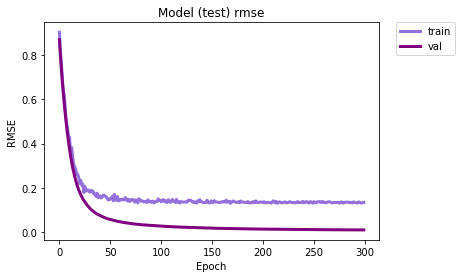

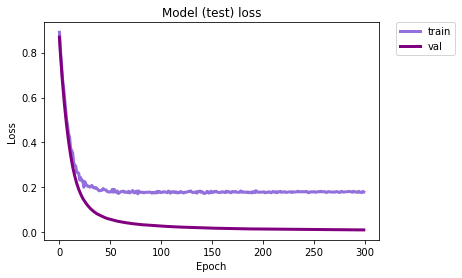

Epoch 1/300
5/5 [==============================] - 0s 59ms/step - loss: 0.1403 - mae: 0.0603 - rmse: 0.1332 - val_loss: 0.1010 - val_mae: 0.0432 - val_rmse: 0.1010
Epoch 2/300
5/5 [==============================] - 0s 46ms/step - loss: 0.1406 - mae: 0.0611 - rmse: 0.1348 - val_loss: 0.1010 - val_mae: 0.0432 - val_rmse: 0.1010
Epoch 3/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1405 - mae: 0.0597 - rmse: 0.1347 - val_loss: 0.1010 - val_mae: 0.0432 - val_rmse: 0.1010
Epoch 4/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1391 - mae: 0.0617 - rmse: 0.1333 - val_loss: 0.1010 - val_mae: 0.0432 - val_rmse: 0.1010
Epoch 5/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1416 - mae: 0.0618 - rmse: 0.1359 - val_loss: 0.1010 - val_mae: 0.0432 - val_rmse: 0.1010
Epoch 6/300
5/5 [==============================] - 0s 50ms/step - loss: 0.1395 - mae: 0.0597 - rmse: 0.1327 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1397 - mae: 0.0605 - rmse: 0.1330 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 52/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1399 - mae: 0.0605 - rmse: 0.1328 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 53/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1405 - mae: 0.0606 - rmse: 0.1346 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 54/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1416 - mae: 0.0618 - rmse: 0.1356 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 55/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1402 - mae: 0.0608 - rmse: 0.1342 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 56/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1404 - mae: 0.0600 - rmse: 0.1342 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 57/3

Epoch 101/300
5/5 [==============================] - 0s 53ms/step - loss: 0.1402 - mae: 0.0616 - rmse: 0.1341 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 102/300
5/5 [==============================] - 0s 50ms/step - loss: 0.1415 - mae: 0.0624 - rmse: 0.1350 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 103/300
5/5 [==============================] - 0s 51ms/step - loss: 0.1399 - mae: 0.0601 - rmse: 0.1335 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 104/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1425 - mae: 0.0626 - rmse: 0.1355 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 105/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1399 - mae: 0.0596 - rmse: 0.1340 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoch 106/300
5/5 [==============================] - 0s 52ms/step - loss: 0.1429 - mae: 0.0622 - rmse: 0.1368 - val_loss: 0.1009 - val_mae: 0.0433 - val_rmse: 0.1009
Epoc

5/5 [==============================] - 0s 50ms/step - loss: 0.1400 - mae: 0.0615 - rmse: 0.1330 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 151/300
5/5 [==============================] - 0s 52ms/step - loss: 0.1420 - mae: 0.0619 - rmse: 0.1361 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 152/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1393 - mae: 0.0605 - rmse: 0.1333 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 153/300
5/5 [==============================] - 0s 53ms/step - loss: 0.1410 - mae: 0.0603 - rmse: 0.1340 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 154/300
5/5 [==============================] - 0s 52ms/step - loss: 0.1424 - mae: 0.0638 - rmse: 0.1363 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 155/300
5/5 [==============================] - 0s 50ms/step - loss: 0.1402 - mae: 0.0621 - rmse: 0.1337 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 156/300
5/5 

5/5 [==============================] - 0s 50ms/step - loss: 0.1421 - mae: 0.0621 - rmse: 0.1364 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 200/300
5/5 [==============================] - 0s 47ms/step - loss: 0.1406 - mae: 0.0614 - rmse: 0.1346 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 201/300
5/5 [==============================] - 0s 50ms/step - loss: 0.1423 - mae: 0.0625 - rmse: 0.1354 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 202/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1417 - mae: 0.0622 - rmse: 0.1352 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 203/300
5/5 [==============================] - 0s 50ms/step - loss: 0.1422 - mae: 0.0619 - rmse: 0.1360 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 204/300
5/5 [==============================] - 0s 51ms/step - loss: 0.1409 - mae: 0.0614 - rmse: 0.1352 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 205/300
5/5 

5/5 [==============================] - 0s 52ms/step - loss: 0.1391 - mae: 0.0595 - rmse: 0.1327 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 249/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1405 - mae: 0.0618 - rmse: 0.1349 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 250/300
5/5 [==============================] - 0s 51ms/step - loss: 0.1411 - mae: 0.0621 - rmse: 0.1355 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 251/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1406 - mae: 0.0626 - rmse: 0.1340 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 252/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1388 - mae: 0.0605 - rmse: 0.1334 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 253/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1419 - mae: 0.0619 - rmse: 0.1357 - val_loss: 0.1009 - val_mae: 0.0434 - val_rmse: 0.1009
Epoch 254/300
5/5 

5/5 [==============================] - 0s 51ms/step - loss: 0.1414 - mae: 0.0616 - rmse: 0.1351 - val_loss: 0.1008 - val_mae: 0.0434 - val_rmse: 0.1008
Epoch 298/300
5/5 [==============================] - 0s 48ms/step - loss: 0.1408 - mae: 0.0608 - rmse: 0.1347 - val_loss: 0.1008 - val_mae: 0.0434 - val_rmse: 0.1008
Epoch 299/300
5/5 [==============================] - 0s 50ms/step - loss: 0.1412 - mae: 0.0612 - rmse: 0.1351 - val_loss: 0.1008 - val_mae: 0.0434 - val_rmse: 0.1008
Epoch 300/300
5/5 [==============================] - 0s 49ms/step - loss: 0.1419 - mae: 0.0617 - rmse: 0.1364 - val_loss: 0.1008 - val_mae: 0.0434 - val_rmse: 0.1008
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


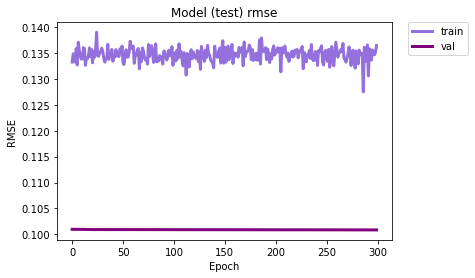

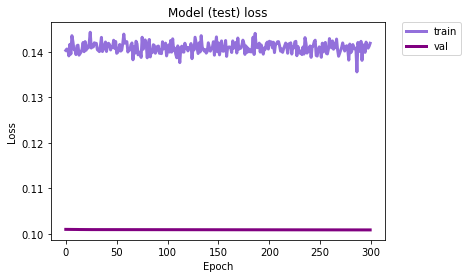

Epoch 1/300
7/7 [==============================] - 0s 54ms/step - loss: 0.1340 - mae: 0.0602 - rmse: 0.1603 - val_loss: 0.1741 - val_mae: 0.0881 - val_rmse: 0.1012
Epoch 2/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1346 - mae: 0.0595 - rmse: 0.1614 - val_loss: 0.1741 - val_mae: 0.0881 - val_rmse: 0.1012
Epoch 3/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1348 - mae: 0.0597 - rmse: 0.1615 - val_loss: 0.1741 - val_mae: 0.0881 - val_rmse: 0.1012
Epoch 4/300
7/7 [==============================] - 0s 45ms/step - loss: 0.1373 - mae: 0.0604 - rmse: 0.1634 - val_loss: 0.1741 - val_mae: 0.0881 - val_rmse: 0.1012
Epoch 5/300
7/7 [==============================] - 0s 48ms/step - loss: 0.1338 - mae: 0.0592 - rmse: 0.1592 - val_loss: 0.1741 - val_mae: 0.0881 - val_rmse: 0.1012
Epoch 6/300
7/7 [==============================] - 0s 50ms/step - loss: 0.1349 - mae: 0.0605 - rmse: 0.1615 - val_loss: 0.1741 - val_mae: 0.0881 - val_rmse: 0.1012
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1331 - mae: 0.0592 - rmse: 0.1600 - val_loss: 0.1740 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 52/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1347 - mae: 0.0598 - rmse: 0.1612 - val_loss: 0.1740 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 53/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1377 - mae: 0.0603 - rmse: 0.1643 - val_loss: 0.1740 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 54/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1339 - mae: 0.0596 - rmse: 0.1608 - val_loss: 0.1740 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 55/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1356 - mae: 0.0608 - rmse: 0.1620 - val_loss: 0.1740 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 56/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1362 - mae: 0.0602 - rmse: 0.1627 - val_loss: 0.1740 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 62ms/step - loss: 0.1364 - mae: 0.0604 - rmse: 0.1629 - val_loss: 0.1739 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 102/300
7/7 [==============================] - 0s 73ms/step - loss: 0.1342 - mae: 0.0589 - rmse: 0.1605 - val_loss: 0.1739 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 103/300
7/7 [==============================] - 0s 70ms/step - loss: 0.1354 - mae: 0.0595 - rmse: 0.1619 - val_loss: 0.1739 - val_mae: 0.0882 - val_rmse: 0.1013
Epoch 104/300
7/7 [==============================] - 0s 74ms/step - loss: 0.1336 - mae: 0.0591 - rmse: 0.1599 - val_loss: 0.1739 - val_mae: 0.0882 - val_rmse: 0.1014
Epoch 105/300
7/7 [==============================] - 0s 72ms/step - loss: 0.1304 - mae: 0.0574 - rmse: 0.1575 - val_loss: 0.1739 - val_mae: 0.0882 - val_rmse: 0.1014
Epoch 106/300
7/7 [==============================] - 0s 61ms/step - loss: 0.1352 - mae: 0.0594 - rmse: 0.1613 - val_loss: 0.1739 - val_mae: 0.0882 - val_rmse: 0.1014
Epoc

7/7 [==============================] - 0s 50ms/step - loss: 0.1356 - mae: 0.0611 - rmse: 0.1619 - val_loss: 0.1739 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 151/300
7/7 [==============================] - 0s 57ms/step - loss: 0.1359 - mae: 0.0608 - rmse: 0.1626 - val_loss: 0.1739 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 152/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1349 - mae: 0.0610 - rmse: 0.1614 - val_loss: 0.1739 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 153/300
7/7 [==============================] - 0s 49ms/step - loss: 0.1338 - mae: 0.0586 - rmse: 0.1601 - val_loss: 0.1739 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 154/300
7/7 [==============================] - 0s 48ms/step - loss: 0.1353 - mae: 0.0599 - rmse: 0.1614 - val_loss: 0.1739 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 155/300
7/7 [==============================] - 0s 53ms/step - loss: 0.1357 - mae: 0.0596 - rmse: 0.1623 - val_loss: 0.1739 - val_mae: 0.0883 - val_rmse: 0.1014
Epoch 156/300
7/7 

7/7 [==============================] - 0s 49ms/step - loss: 0.1354 - mae: 0.0604 - rmse: 0.1600 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 200/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1349 - mae: 0.0601 - rmse: 0.1617 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 201/300
7/7 [==============================] - 0s 50ms/step - loss: 0.1360 - mae: 0.0604 - rmse: 0.1625 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 202/300
7/7 [==============================] - 0s 50ms/step - loss: 0.1351 - mae: 0.0614 - rmse: 0.1620 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 203/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1363 - mae: 0.0611 - rmse: 0.1624 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 204/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1351 - mae: 0.0591 - rmse: 0.1614 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 205/300
7/7 

7/7 [==============================] - 0s 46ms/step - loss: 0.1353 - mae: 0.0609 - rmse: 0.1621 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 249/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1357 - mae: 0.0608 - rmse: 0.1623 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 250/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1355 - mae: 0.0601 - rmse: 0.1622 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 251/300
7/7 [==============================] - 0s 45ms/step - loss: 0.1360 - mae: 0.0608 - rmse: 0.1622 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 252/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1361 - mae: 0.0597 - rmse: 0.1626 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 253/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1358 - mae: 0.0622 - rmse: 0.1625 - val_loss: 0.1738 - val_mae: 0.0884 - val_rmse: 0.1015
Epoch 254/300
7/7 

7/7 [==============================] - 1s 94ms/step - loss: 0.1359 - mae: 0.0609 - rmse: 0.1625 - val_loss: 0.1737 - val_mae: 0.0885 - val_rmse: 0.1016
Epoch 298/300
7/7 [==============================] - 0s 51ms/step - loss: 0.1357 - mae: 0.0610 - rmse: 0.1623 - val_loss: 0.1737 - val_mae: 0.0885 - val_rmse: 0.1016
Epoch 299/300
7/7 [==============================] - 0s 49ms/step - loss: 0.1343 - mae: 0.0603 - rmse: 0.1612 - val_loss: 0.1737 - val_mae: 0.0885 - val_rmse: 0.1016
Epoch 300/300
7/7 [==============================] - 0s 48ms/step - loss: 0.1334 - mae: 0.0598 - rmse: 0.1597 - val_loss: 0.1737 - val_mae: 0.0885 - val_rmse: 0.1016
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


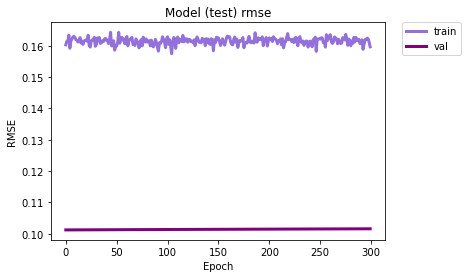

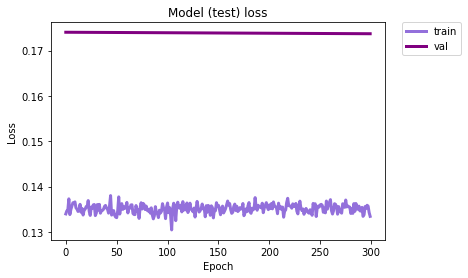

Epoch 1/300
9/9 [==============================] - 0s 49ms/step - loss: 0.1327 - mae: 0.0587 - rmse: 0.1240 - val_loss: 0.1100 - val_mae: 0.0583 - val_rmse: 0.1430
Epoch 2/300
9/9 [==============================] - 0s 43ms/step - loss: 0.1327 - mae: 0.0585 - rmse: 0.1245 - val_loss: 0.1100 - val_mae: 0.0583 - val_rmse: 0.1430
Epoch 3/300
9/9 [==============================] - 0s 43ms/step - loss: 0.1337 - mae: 0.0599 - rmse: 0.1261 - val_loss: 0.1100 - val_mae: 0.0583 - val_rmse: 0.1430
Epoch 4/300
9/9 [==============================] - 0s 43ms/step - loss: 0.1322 - mae: 0.0600 - rmse: 0.1237 - val_loss: 0.1100 - val_mae: 0.0583 - val_rmse: 0.1430
Epoch 5/300
9/9 [==============================] - 0s 43ms/step - loss: 0.1324 - mae: 0.0585 - rmse: 0.1243 - val_loss: 0.1100 - val_mae: 0.0583 - val_rmse: 0.1430
Epoch 6/300
9/9 [==============================] - 0s 49ms/step - loss: 0.1315 - mae: 0.0583 - rmse: 0.1226 - val_loss: 0.1100 - val_mae: 0.0583 - val_rmse: 0.1430
Epoch 7/300
9/9 

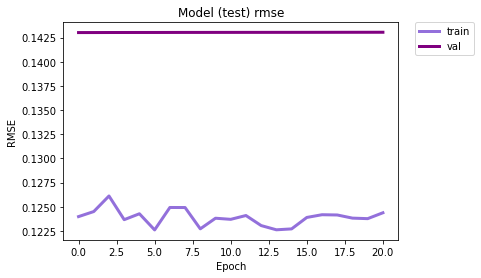

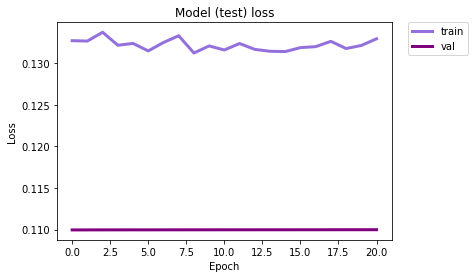

Epoch 1/300
11/11 [==============================] - 1s 47ms/step - loss: 0.1337 - mae: 0.0601 - rmse: 0.1327 - val_loss: 0.3112 - val_mae: 0.1198 - val_rmse: 0.3152
Epoch 2/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1333 - mae: 0.0602 - rmse: 0.1325 - val_loss: 0.3112 - val_mae: 0.1198 - val_rmse: 0.3152
Epoch 3/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1343 - mae: 0.0621 - rmse: 0.1335 - val_loss: 0.3112 - val_mae: 0.1198 - val_rmse: 0.3152
Epoch 4/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1332 - mae: 0.0597 - rmse: 0.1321 - val_loss: 0.3112 - val_mae: 0.1198 - val_rmse: 0.3152
Epoch 5/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1334 - mae: 0.0606 - rmse: 0.1325 - val_loss: 0.3112 - val_mae: 0.1198 - val_rmse: 0.3152
Epoch 6/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1321 - mae: 0.0612 - rmse: 0.1315 - val_loss: 0.3112 - val_mae: 0.1198 - val_rmse: 0.3152
Epoc

11/11 [==============================] - 0s 45ms/step - loss: 0.1336 - mae: 0.0617 - rmse: 0.1328 - val_loss: 0.3111 - val_mae: 0.1199 - val_rmse: 0.3151
Epoch 51/300
11/11 [==============================] - 1s 48ms/step - loss: 0.1323 - mae: 0.0616 - rmse: 0.1315 - val_loss: 0.3111 - val_mae: 0.1199 - val_rmse: 0.3151
Epoch 52/300
11/11 [==============================] - 1s 50ms/step - loss: 0.1313 - mae: 0.0593 - rmse: 0.1306 - val_loss: 0.3111 - val_mae: 0.1199 - val_rmse: 0.3151
Epoch 53/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1326 - mae: 0.0620 - rmse: 0.1320 - val_loss: 0.3111 - val_mae: 0.1199 - val_rmse: 0.3151
Epoch 54/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1326 - mae: 0.0614 - rmse: 0.1320 - val_loss: 0.3111 - val_mae: 0.1199 - val_rmse: 0.3151
Epoch 55/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1330 - mae: 0.0615 - rmse: 0.1322 - val_loss: 0.3111 - val_mae: 0.1199 - val_rmse: 0.3151
Epoch 56/30

11/11 [==============================] - 1s 46ms/step - loss: 0.1339 - mae: 0.0614 - rmse: 0.1331 - val_loss: 0.3109 - val_mae: 0.1201 - val_rmse: 0.3149
Epoch 100/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1320 - mae: 0.0599 - rmse: 0.1310 - val_loss: 0.3109 - val_mae: 0.1201 - val_rmse: 0.3149
Epoch 101/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1332 - mae: 0.0609 - rmse: 0.1325 - val_loss: 0.3109 - val_mae: 0.1201 - val_rmse: 0.3149
Epoch 102/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1324 - mae: 0.0605 - rmse: 0.1313 - val_loss: 0.3109 - val_mae: 0.1201 - val_rmse: 0.3149
Epoch 103/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1340 - mae: 0.0609 - rmse: 0.1333 - val_loss: 0.3109 - val_mae: 0.1201 - val_rmse: 0.3149
Epoch 104/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1323 - mae: 0.0595 - rmse: 0.1317 - val_loss: 0.3109 - val_mae: 0.1201 - val_rmse: 0.3149
Epoch 

Epoch 148/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1331 - mae: 0.0617 - rmse: 0.1319 - val_loss: 0.3108 - val_mae: 0.1202 - val_rmse: 0.3148
Epoch 149/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1322 - mae: 0.0609 - rmse: 0.1315 - val_loss: 0.3108 - val_mae: 0.1202 - val_rmse: 0.3148
Epoch 150/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1327 - mae: 0.0614 - rmse: 0.1319 - val_loss: 0.3108 - val_mae: 0.1202 - val_rmse: 0.3148
Epoch 151/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1334 - mae: 0.0611 - rmse: 0.1323 - val_loss: 0.3108 - val_mae: 0.1203 - val_rmse: 0.3148
Epoch 152/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1329 - mae: 0.0607 - rmse: 0.1319 - val_loss: 0.3108 - val_mae: 0.1203 - val_rmse: 0.3148
Epoch 153/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1338 - mae: 0.0620 - rmse: 0.1331 - val_loss: 0.3108 - val_mae: 0.1203 - val_rmse:

Epoch 197/300
11/11 [==============================] - 1s 46ms/step - loss: 0.1326 - mae: 0.0618 - rmse: 0.1313 - val_loss: 0.3106 - val_mae: 0.1204 - val_rmse: 0.3146
Epoch 198/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1340 - mae: 0.0625 - rmse: 0.1331 - val_loss: 0.3106 - val_mae: 0.1204 - val_rmse: 0.3146
Epoch 199/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1333 - mae: 0.0627 - rmse: 0.1325 - val_loss: 0.3106 - val_mae: 0.1204 - val_rmse: 0.3146
Epoch 200/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1334 - mae: 0.0616 - rmse: 0.1328 - val_loss: 0.3106 - val_mae: 0.1204 - val_rmse: 0.3146
Epoch 201/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1316 - mae: 0.0619 - rmse: 0.1308 - val_loss: 0.3106 - val_mae: 0.1204 - val_rmse: 0.3146
Epoch 202/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1330 - mae: 0.0616 - rmse: 0.1322 - val_loss: 0.3106 - val_mae: 0.1204 - val_rmse:

Epoch 246/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1333 - mae: 0.0624 - rmse: 0.1321 - val_loss: 0.3105 - val_mae: 0.1206 - val_rmse: 0.3145
Epoch 247/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1322 - mae: 0.0605 - rmse: 0.1315 - val_loss: 0.3105 - val_mae: 0.1206 - val_rmse: 0.3145
Epoch 248/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1334 - mae: 0.0623 - rmse: 0.1327 - val_loss: 0.3105 - val_mae: 0.1206 - val_rmse: 0.3145
Epoch 249/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1321 - mae: 0.0618 - rmse: 0.1314 - val_loss: 0.3105 - val_mae: 0.1206 - val_rmse: 0.3145
Epoch 250/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1337 - mae: 0.0627 - rmse: 0.1328 - val_loss: 0.3105 - val_mae: 0.1206 - val_rmse: 0.3145
Epoch 251/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1343 - mae: 0.0616 - rmse: 0.1336 - val_loss: 0.3105 - val_mae: 0.1206 - val_rmse:

Epoch 295/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1320 - mae: 0.0611 - rmse: 0.1311 - val_loss: 0.3104 - val_mae: 0.1207 - val_rmse: 0.3143
Epoch 296/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1341 - mae: 0.0627 - rmse: 0.1335 - val_loss: 0.3104 - val_mae: 0.1207 - val_rmse: 0.3143
Epoch 297/300
11/11 [==============================] - 0s 44ms/step - loss: 0.1337 - mae: 0.0630 - rmse: 0.1330 - val_loss: 0.3104 - val_mae: 0.1208 - val_rmse: 0.3143
Epoch 298/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1339 - mae: 0.0624 - rmse: 0.1329 - val_loss: 0.3104 - val_mae: 0.1208 - val_rmse: 0.3143
Epoch 299/300
11/11 [==============================] - 0s 46ms/step - loss: 0.1334 - mae: 0.0629 - rmse: 0.1322 - val_loss: 0.3104 - val_mae: 0.1208 - val_rmse: 0.3143
Epoch 300/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1329 - mae: 0.0622 - rmse: 0.1322 - val_loss: 0.3104 - val_mae: 0.1208 - val_rmse:

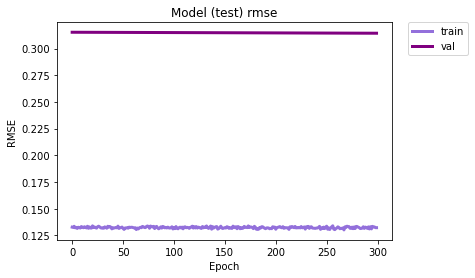

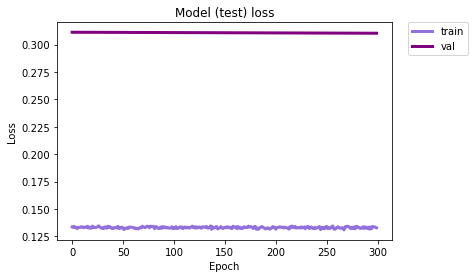

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9816469
Transformed yhat 27.71139
yhat -0.982438
Transformed yhat 27.691713
yhat -0.9825866
Transformed yhat 27.688017
yhat -0.982724
Transformed yhat 27.6846
yhat -0.982853
Transformed yhat 27.681393
yhat -0.9829825
Transformed yhat 27.67817
yhat -0.98311377
Transformed yhat 27.674906
yhat -0.9833185
Transformed yhat 27.669815
yhat -0.9836541
Transformed yhat 27.661469
yhat -0.98385274
Transformed yhat 27.656525
yhat -0.9838486
Transformed yhat 27.65663
yhat -0.9838421
Transformed yhat 27.656792
Real data: [59.65684059 27.25490196 27.41444597 27.733534   28.5920593  29.57554215
 35.37714262 46.03200502 39.90239099 27.51095337 27.25490196 27.25490196
 27.25490196 27.25490196 27.25490196 27.25490196 29.32897413 27.25490196
 28.06712603 27.25490196 27.25490196 27.25490196 27.90758201 28.30898025]
Forecasting values: [27.7, 27.7, 27.7, 27.7, 27.7, 27.7, 27.7, 27.7, 27.7, 27.7, 27.7, 27.7]


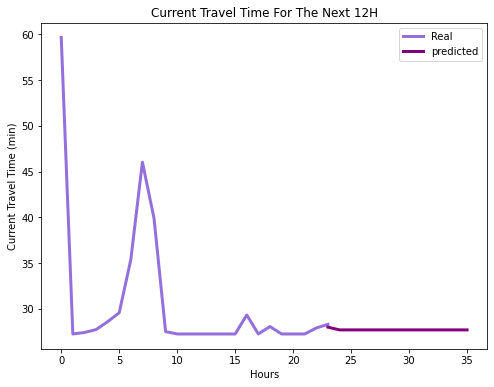

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.4',forecasts[i],hour[i]
        writer.writerow(d)

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 5s 454ms/step - loss: 0.8741 - mae: 0.8484 - rmse: 0.8817 - val_loss: 0.8295 - val_mae: 0.8293 - val_rmse: 0.8295
Epoch 2/300
3/3 [==============================] - 0s 66ms/step - loss: 0.8050 - mae: 0.7818 - rmse: 0.8067 - val_loss: 0.7636 - val_mae: 0.7635 - val_rmse: 0.7636
Epoch 3/300
3/3 [==============================] - 0s 77ms/step - loss: 0.7441 - mae: 0.7213 - rmse: 0.7413 - val_loss: 0.7023 - val_mae: 0.7021 - val_rmse: 0.7023
Epoch 4/300
3/3 [==============================] - 0s 71ms/step - loss: 0.6891 - mae: 0.6722 - rmse: 0.6948 - val_loss: 0.6479 - val_mae: 0.6478 - val_rmse: 0.6479
Epoch 5/300
3/3 [==============================] - 0s 73ms/step - loss: 0.6519 - mae: 0.6351 - rmse: 0.6438 - val_loss: 0.5977 - val_mae: 0.5975 - val_rmse: 0.5977
Epoch 6/300
3/3 [==============================] - 0s 66ms/step - loss: 0.6049 - mae: 0.5888 - rmse: 0.6025 - val_loss: 0.5506 - val_mae: 0.5504 - val_rmse: 0.5506
Epoch 7/300
3/3

Epoch 51/300
3/3 [==============================] - 0s 59ms/step - loss: 0.2870 - mae: 0.1655 - rmse: 0.2575 - val_loss: 0.0419 - val_mae: 0.0397 - val_rmse: 0.0419
Epoch 52/300
3/3 [==============================] - 0s 62ms/step - loss: 0.2800 - mae: 0.1574 - rmse: 0.2588 - val_loss: 0.0401 - val_mae: 0.0383 - val_rmse: 0.0401
Epoch 53/300
3/3 [==============================] - 0s 60ms/step - loss: 0.2778 - mae: 0.1541 - rmse: 0.2545 - val_loss: 0.0386 - val_mae: 0.0370 - val_rmse: 0.0386
Epoch 54/300
3/3 [==============================] - 0s 62ms/step - loss: 0.2740 - mae: 0.1573 - rmse: 0.2495 - val_loss: 0.0373 - val_mae: 0.0359 - val_rmse: 0.0373
Epoch 55/300
3/3 [==============================] - 0s 63ms/step - loss: 0.2816 - mae: 0.1613 - rmse: 0.2516 - val_loss: 0.0362 - val_mae: 0.0350 - val_rmse: 0.0362
Epoch 56/300
3/3 [==============================] - 0s 60ms/step - loss: 0.2849 - mae: 0.1586 - rmse: 0.2551 - val_loss: 0.0350 - val_mae: 0.0339 - val_rmse: 0.0350
Epoch 57/3

Epoch 101/300
3/3 [==============================] - 0s 58ms/step - loss: 0.2766 - mae: 0.1362 - rmse: 0.2450 - val_loss: 0.0155 - val_mae: 0.0127 - val_rmse: 0.0155
Epoch 102/300
3/3 [==============================] - 0s 61ms/step - loss: 0.2880 - mae: 0.1418 - rmse: 0.2553 - val_loss: 0.0154 - val_mae: 0.0124 - val_rmse: 0.0154
Epoch 103/300
3/3 [==============================] - 0s 81ms/step - loss: 0.2794 - mae: 0.1401 - rmse: 0.2465 - val_loss: 0.0154 - val_mae: 0.0124 - val_rmse: 0.0154
Epoch 104/300
3/3 [==============================] - 0s 58ms/step - loss: 0.2880 - mae: 0.1441 - rmse: 0.2564 - val_loss: 0.0153 - val_mae: 0.0121 - val_rmse: 0.0153
Epoch 105/300
3/3 [==============================] - 0s 64ms/step - loss: 0.2916 - mae: 0.1475 - rmse: 0.2617 - val_loss: 0.0151 - val_mae: 0.0116 - val_rmse: 0.0151
Epoch 106/300
3/3 [==============================] - 0s 65ms/step - loss: 0.2751 - mae: 0.1311 - rmse: 0.2431 - val_loss: 0.0152 - val_mae: 0.0117 - val_rmse: 0.0152
Epoc

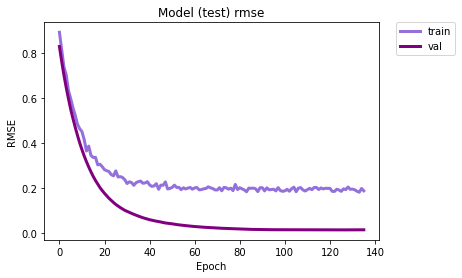

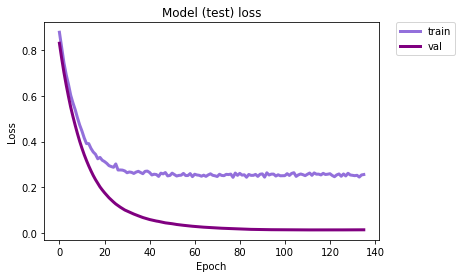

Epoch 1/300
5/5 [==============================] - 0s 90ms/step - loss: 0.2322 - mae: 0.1160 - rmse: 0.2259 - val_loss: 0.2044 - val_mae: 0.0897 - val_rmse: 0.2044
Epoch 2/300
5/5 [==============================] - 0s 61ms/step - loss: 0.2283 - mae: 0.1143 - rmse: 0.2241 - val_loss: 0.2044 - val_mae: 0.0898 - val_rmse: 0.2044
Epoch 3/300
5/5 [==============================] - 0s 75ms/step - loss: 0.2219 - mae: 0.1092 - rmse: 0.2167 - val_loss: 0.2043 - val_mae: 0.0898 - val_rmse: 0.2043
Epoch 4/300
5/5 [==============================] - 0s 71ms/step - loss: 0.2324 - mae: 0.1158 - rmse: 0.2285 - val_loss: 0.2043 - val_mae: 0.0898 - val_rmse: 0.2043
Epoch 5/300
5/5 [==============================] - 0s 48ms/step - loss: 0.2338 - mae: 0.1160 - rmse: 0.2259 - val_loss: 0.2043 - val_mae: 0.0898 - val_rmse: 0.2043
Epoch 6/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2292 - mae: 0.1123 - rmse: 0.2229 - val_loss: 0.2043 - val_mae: 0.0898 - val_rmse: 0.2043
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2332 - mae: 0.1201 - rmse: 0.2301 - val_loss: 0.2041 - val_mae: 0.0901 - val_rmse: 0.2041
Epoch 52/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2296 - mae: 0.1167 - rmse: 0.2261 - val_loss: 0.2041 - val_mae: 0.0901 - val_rmse: 0.2041
Epoch 53/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2362 - mae: 0.1213 - rmse: 0.2323 - val_loss: 0.2041 - val_mae: 0.0901 - val_rmse: 0.2041
Epoch 54/300
5/5 [==============================] - 0s 48ms/step - loss: 0.2289 - mae: 0.1177 - rmse: 0.2225 - val_loss: 0.2041 - val_mae: 0.0901 - val_rmse: 0.2041
Epoch 55/300
5/5 [==============================] - 0s 48ms/step - loss: 0.2342 - mae: 0.1150 - rmse: 0.2275 - val_loss: 0.2041 - val_mae: 0.0901 - val_rmse: 0.2041
Epoch 56/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2291 - mae: 0.1150 - rmse: 0.2241 - val_loss: 0.2040 - val_mae: 0.0901 - val_rmse: 0.2040
Epoch 57/3

Epoch 101/300
5/5 [==============================] - 0s 59ms/step - loss: 0.2309 - mae: 0.1159 - rmse: 0.2264 - val_loss: 0.2038 - val_mae: 0.0903 - val_rmse: 0.2038
Epoch 102/300
5/5 [==============================] - 0s 55ms/step - loss: 0.2328 - mae: 0.1188 - rmse: 0.2276 - val_loss: 0.2038 - val_mae: 0.0903 - val_rmse: 0.2038
Epoch 103/300
5/5 [==============================] - 0s 66ms/step - loss: 0.2283 - mae: 0.1152 - rmse: 0.2241 - val_loss: 0.2038 - val_mae: 0.0903 - val_rmse: 0.2038
Epoch 104/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2310 - mae: 0.1168 - rmse: 0.2273 - val_loss: 0.2038 - val_mae: 0.0903 - val_rmse: 0.2038
Epoch 105/300
5/5 [==============================] - 0s 72ms/step - loss: 0.2320 - mae: 0.1145 - rmse: 0.2286 - val_loss: 0.2038 - val_mae: 0.0903 - val_rmse: 0.2038
Epoch 106/300
5/5 [==============================] - 0s 88ms/step - loss: 0.2314 - mae: 0.1142 - rmse: 0.2273 - val_loss: 0.2038 - val_mae: 0.0903 - val_rmse: 0.2038
Epoc

5/5 [==============================] - 0s 53ms/step - loss: 0.2293 - mae: 0.1150 - rmse: 0.2274 - val_loss: 0.2036 - val_mae: 0.0906 - val_rmse: 0.2036
Epoch 151/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2299 - mae: 0.1160 - rmse: 0.2249 - val_loss: 0.2036 - val_mae: 0.0906 - val_rmse: 0.2036
Epoch 152/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2290 - mae: 0.1163 - rmse: 0.2226 - val_loss: 0.2036 - val_mae: 0.0906 - val_rmse: 0.2036
Epoch 153/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2265 - mae: 0.1141 - rmse: 0.2216 - val_loss: 0.2036 - val_mae: 0.0906 - val_rmse: 0.2036
Epoch 154/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2307 - mae: 0.1184 - rmse: 0.2240 - val_loss: 0.2036 - val_mae: 0.0906 - val_rmse: 0.2036
Epoch 155/300
5/5 [==============================] - 0s 52ms/step - loss: 0.2288 - mae: 0.1189 - rmse: 0.2248 - val_loss: 0.2036 - val_mae: 0.0906 - val_rmse: 0.2036
Epoch 156/300
5/5 

5/5 [==============================] - 0s 54ms/step - loss: 0.2295 - mae: 0.1155 - rmse: 0.2227 - val_loss: 0.2034 - val_mae: 0.0908 - val_rmse: 0.2034
Epoch 200/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2283 - mae: 0.1134 - rmse: 0.2236 - val_loss: 0.2034 - val_mae: 0.0909 - val_rmse: 0.2034
Epoch 201/300
5/5 [==============================] - 0s 48ms/step - loss: 0.2262 - mae: 0.1110 - rmse: 0.2233 - val_loss: 0.2034 - val_mae: 0.0909 - val_rmse: 0.2034
Epoch 202/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2307 - mae: 0.1152 - rmse: 0.2253 - val_loss: 0.2034 - val_mae: 0.0909 - val_rmse: 0.2034
Epoch 203/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2314 - mae: 0.1203 - rmse: 0.2256 - val_loss: 0.2034 - val_mae: 0.0909 - val_rmse: 0.2034
Epoch 204/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2329 - mae: 0.1183 - rmse: 0.2292 - val_loss: 0.2034 - val_mae: 0.0909 - val_rmse: 0.2034
Epoch 205/300
5/5 

5/5 [==============================] - 0s 53ms/step - loss: 0.2244 - mae: 0.1139 - rmse: 0.2207 - val_loss: 0.2032 - val_mae: 0.0910 - val_rmse: 0.2032
Epoch 249/300
5/5 [==============================] - 0s 71ms/step - loss: 0.2290 - mae: 0.1128 - rmse: 0.2216 - val_loss: 0.2032 - val_mae: 0.0911 - val_rmse: 0.2032
Epoch 250/300
5/5 [==============================] - 0s 52ms/step - loss: 0.2288 - mae: 0.1167 - rmse: 0.2272 - val_loss: 0.2032 - val_mae: 0.0911 - val_rmse: 0.2032
Epoch 251/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2257 - mae: 0.1182 - rmse: 0.2212 - val_loss: 0.2032 - val_mae: 0.0911 - val_rmse: 0.2032
Epoch 252/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2334 - mae: 0.1189 - rmse: 0.2275 - val_loss: 0.2032 - val_mae: 0.0911 - val_rmse: 0.2032
Epoch 253/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2352 - mae: 0.1223 - rmse: 0.2310 - val_loss: 0.2032 - val_mae: 0.0911 - val_rmse: 0.2032
Epoch 254/300
5/5 

5/5 [==============================] - 0s 51ms/step - loss: 0.2285 - mae: 0.1159 - rmse: 0.2254 - val_loss: 0.2031 - val_mae: 0.0912 - val_rmse: 0.2031
Epoch 298/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2326 - mae: 0.1176 - rmse: 0.2267 - val_loss: 0.2031 - val_mae: 0.0912 - val_rmse: 0.2031
Epoch 299/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2284 - mae: 0.1159 - rmse: 0.2239 - val_loss: 0.2031 - val_mae: 0.0912 - val_rmse: 0.2031
Epoch 300/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2232 - mae: 0.1142 - rmse: 0.2166 - val_loss: 0.2031 - val_mae: 0.0912 - val_rmse: 0.2031
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


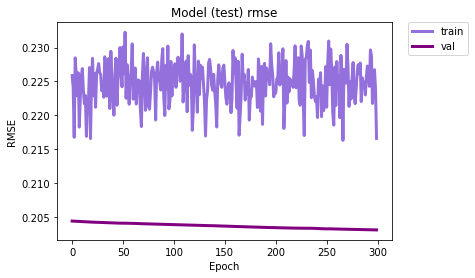

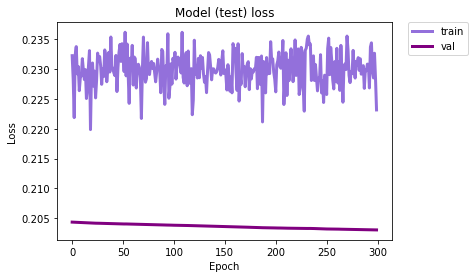

Epoch 1/300
7/7 [==============================] - 0s 55ms/step - loss: 0.2243 - mae: 0.1142 - rmse: 0.2545 - val_loss: 0.2780 - val_mae: 0.1651 - val_rmse: 0.1810
Epoch 2/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2211 - mae: 0.1108 - rmse: 0.2538 - val_loss: 0.2780 - val_mae: 0.1651 - val_rmse: 0.1810
Epoch 3/300
7/7 [==============================] - 0s 49ms/step - loss: 0.2248 - mae: 0.1166 - rmse: 0.2572 - val_loss: 0.2780 - val_mae: 0.1651 - val_rmse: 0.1810
Epoch 4/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2276 - mae: 0.1174 - rmse: 0.2590 - val_loss: 0.2780 - val_mae: 0.1651 - val_rmse: 0.1811
Epoch 5/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2262 - mae: 0.1164 - rmse: 0.2602 - val_loss: 0.2780 - val_mae: 0.1651 - val_rmse: 0.1811
Epoch 6/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2267 - mae: 0.1178 - rmse: 0.2585 - val_loss: 0.2780 - val_mae: 0.1651 - val_rmse: 0.1811
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2203 - mae: 0.1098 - rmse: 0.2520 - val_loss: 0.2777 - val_mae: 0.1655 - val_rmse: 0.1814
Epoch 52/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2290 - mae: 0.1181 - rmse: 0.2613 - val_loss: 0.2777 - val_mae: 0.1655 - val_rmse: 0.1815
Epoch 53/300
7/7 [==============================] - 0s 47ms/step - loss: 0.2295 - mae: 0.1170 - rmse: 0.2621 - val_loss: 0.2777 - val_mae: 0.1655 - val_rmse: 0.1814
Epoch 54/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2243 - mae: 0.1149 - rmse: 0.2577 - val_loss: 0.2777 - val_mae: 0.1655 - val_rmse: 0.1815
Epoch 55/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2265 - mae: 0.1159 - rmse: 0.2585 - val_loss: 0.2777 - val_mae: 0.1655 - val_rmse: 0.1815
Epoch 56/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2249 - mae: 0.1129 - rmse: 0.2549 - val_loss: 0.2777 - val_mae: 0.1655 - val_rmse: 0.1815
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2218 - mae: 0.1126 - rmse: 0.2553 - val_loss: 0.2775 - val_mae: 0.1658 - val_rmse: 0.1818
Epoch 102/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2252 - mae: 0.1197 - rmse: 0.2546 - val_loss: 0.2775 - val_mae: 0.1658 - val_rmse: 0.1818
Epoch 103/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2254 - mae: 0.1160 - rmse: 0.2579 - val_loss: 0.2775 - val_mae: 0.1658 - val_rmse: 0.1818
Epoch 104/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2231 - mae: 0.1180 - rmse: 0.2562 - val_loss: 0.2775 - val_mae: 0.1658 - val_rmse: 0.1818
Epoch 105/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2281 - mae: 0.1187 - rmse: 0.2604 - val_loss: 0.2775 - val_mae: 0.1658 - val_rmse: 0.1818
Epoch 106/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2290 - mae: 0.1180 - rmse: 0.2614 - val_loss: 0.2775 - val_mae: 0.1658 - val_rmse: 0.1818
Epoc

7/7 [==============================] - 0s 48ms/step - loss: 0.2275 - mae: 0.1179 - rmse: 0.2595 - val_loss: 0.2773 - val_mae: 0.1661 - val_rmse: 0.1820
Epoch 151/300
7/7 [==============================] - 0s 47ms/step - loss: 0.2297 - mae: 0.1160 - rmse: 0.2623 - val_loss: 0.2773 - val_mae: 0.1661 - val_rmse: 0.1820
Epoch 152/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2265 - mae: 0.1141 - rmse: 0.2591 - val_loss: 0.2773 - val_mae: 0.1661 - val_rmse: 0.1821
Epoch 153/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2270 - mae: 0.1175 - rmse: 0.2595 - val_loss: 0.2773 - val_mae: 0.1661 - val_rmse: 0.1821
Epoch 154/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2265 - mae: 0.1168 - rmse: 0.2597 - val_loss: 0.2773 - val_mae: 0.1661 - val_rmse: 0.1821
Epoch 155/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2295 - mae: 0.1194 - rmse: 0.2619 - val_loss: 0.2773 - val_mae: 0.1661 - val_rmse: 0.1821
Epoch 156/300
7/7 

7/7 [==============================] - 0s 48ms/step - loss: 0.2261 - mae: 0.1146 - rmse: 0.2590 - val_loss: 0.2772 - val_mae: 0.1663 - val_rmse: 0.1822
Epoch 200/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2278 - mae: 0.1160 - rmse: 0.2609 - val_loss: 0.2772 - val_mae: 0.1663 - val_rmse: 0.1822
Epoch 201/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2261 - mae: 0.1180 - rmse: 0.2595 - val_loss: 0.2772 - val_mae: 0.1663 - val_rmse: 0.1822
Epoch 202/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2244 - mae: 0.1159 - rmse: 0.2551 - val_loss: 0.2772 - val_mae: 0.1663 - val_rmse: 0.1823
Epoch 203/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2239 - mae: 0.1138 - rmse: 0.2572 - val_loss: 0.2771 - val_mae: 0.1663 - val_rmse: 0.1823
Epoch 204/300
7/7 [==============================] - 0s 49ms/step - loss: 0.2266 - mae: 0.1173 - rmse: 0.2585 - val_loss: 0.2771 - val_mae: 0.1663 - val_rmse: 0.1823
Epoch 205/300
7/7 

7/7 [==============================] - 0s 48ms/step - loss: 0.2268 - mae: 0.1172 - rmse: 0.2598 - val_loss: 0.2770 - val_mae: 0.1665 - val_rmse: 0.1824
Epoch 249/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2274 - mae: 0.1202 - rmse: 0.2568 - val_loss: 0.2770 - val_mae: 0.1665 - val_rmse: 0.1824
Epoch 250/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2281 - mae: 0.1196 - rmse: 0.2596 - val_loss: 0.2770 - val_mae: 0.1665 - val_rmse: 0.1824
Epoch 251/300
7/7 [==============================] - 0s 46ms/step - loss: 0.2221 - mae: 0.1183 - rmse: 0.2524 - val_loss: 0.2770 - val_mae: 0.1665 - val_rmse: 0.1825
Epoch 252/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2225 - mae: 0.1170 - rmse: 0.2556 - val_loss: 0.2770 - val_mae: 0.1665 - val_rmse: 0.1825
Epoch 253/300
7/7 [==============================] - 0s 47ms/step - loss: 0.2269 - mae: 0.1193 - rmse: 0.2602 - val_loss: 0.2770 - val_mae: 0.1665 - val_rmse: 0.1825
Epoch 254/300
7/7 

7/7 [==============================] - 0s 50ms/step - loss: 0.2246 - mae: 0.1169 - rmse: 0.2551 - val_loss: 0.2769 - val_mae: 0.1667 - val_rmse: 0.1826
Epoch 298/300
7/7 [==============================] - 0s 50ms/step - loss: 0.2283 - mae: 0.1220 - rmse: 0.2600 - val_loss: 0.2769 - val_mae: 0.1667 - val_rmse: 0.1826
Epoch 299/300
7/7 [==============================] - 0s 49ms/step - loss: 0.2265 - mae: 0.1179 - rmse: 0.2594 - val_loss: 0.2769 - val_mae: 0.1667 - val_rmse: 0.1826
Epoch 300/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2262 - mae: 0.1180 - rmse: 0.2550 - val_loss: 0.2769 - val_mae: 0.1667 - val_rmse: 0.1827
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


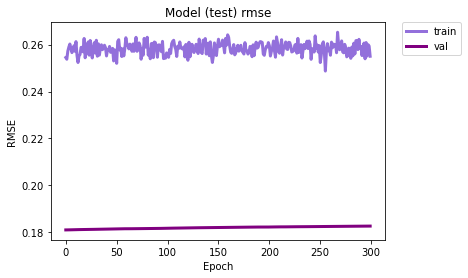

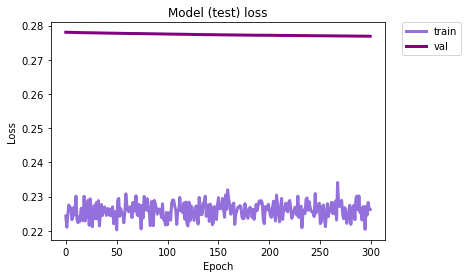

Epoch 1/300
9/9 [==============================] - 0s 50ms/step - loss: 0.2216 - mae: 0.1186 - rmse: 0.2080 - val_loss: 0.1596 - val_mae: 0.0973 - val_rmse: 0.1905
Epoch 2/300
9/9 [==============================] - 0s 43ms/step - loss: 0.2205 - mae: 0.1164 - rmse: 0.2074 - val_loss: 0.1596 - val_mae: 0.0973 - val_rmse: 0.1906
Epoch 3/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2162 - mae: 0.1144 - rmse: 0.2018 - val_loss: 0.1596 - val_mae: 0.0973 - val_rmse: 0.1906
Epoch 4/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2123 - mae: 0.1133 - rmse: 0.1982 - val_loss: 0.1596 - val_mae: 0.0973 - val_rmse: 0.1906
Epoch 5/300
9/9 [==============================] - 0s 44ms/step - loss: 0.2209 - mae: 0.1183 - rmse: 0.2069 - val_loss: 0.1596 - val_mae: 0.0972 - val_rmse: 0.1906
Epoch 6/300
9/9 [==============================] - 0s 45ms/step - loss: 0.2210 - mae: 0.1154 - rmse: 0.2086 - val_loss: 0.1596 - val_mae: 0.0972 - val_rmse: 0.1906
Epoch 7/300
9/9 

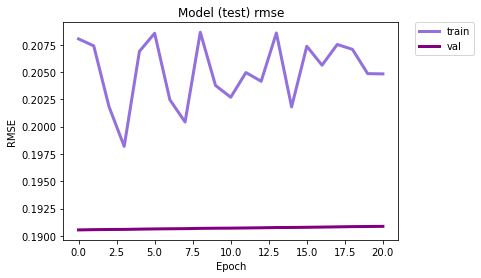

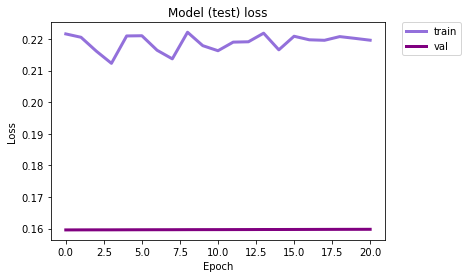

Epoch 1/300
11/11 [==============================] - 1s 50ms/step - loss: 0.2210 - mae: 0.1194 - rmse: 0.2231 - val_loss: 0.3985 - val_mae: 0.1725 - val_rmse: 0.4011
Epoch 2/300
11/11 [==============================] - 1s 46ms/step - loss: 0.2186 - mae: 0.1142 - rmse: 0.2199 - val_loss: 0.3985 - val_mae: 0.1726 - val_rmse: 0.4011
Epoch 3/300
11/11 [==============================] - 0s 44ms/step - loss: 0.2150 - mae: 0.1123 - rmse: 0.2167 - val_loss: 0.3985 - val_mae: 0.1726 - val_rmse: 0.4011
Epoch 4/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2161 - mae: 0.1168 - rmse: 0.2181 - val_loss: 0.3984 - val_mae: 0.1726 - val_rmse: 0.4011
Epoch 5/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2171 - mae: 0.1168 - rmse: 0.2192 - val_loss: 0.3984 - val_mae: 0.1726 - val_rmse: 0.4010
Epoch 6/300
11/11 [==============================] - 0s 42ms/step - loss: 0.2151 - mae: 0.1148 - rmse: 0.2166 - val_loss: 0.3984 - val_mae: 0.1727 - val_rmse: 0.4010
Epoc

11/11 [==============================] - 0s 44ms/step - loss: 0.2191 - mae: 0.1176 - rmse: 0.2210 - val_loss: 0.3979 - val_mae: 0.1735 - val_rmse: 0.4005
Epoch 51/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2173 - mae: 0.1180 - rmse: 0.2182 - val_loss: 0.3979 - val_mae: 0.1735 - val_rmse: 0.4005
Epoch 52/300
11/11 [==============================] - 0s 45ms/step - loss: 0.2162 - mae: 0.1155 - rmse: 0.2183 - val_loss: 0.3979 - val_mae: 0.1735 - val_rmse: 0.4005
Epoch 53/300
11/11 [==============================] - 0s 46ms/step - loss: 0.2186 - mae: 0.1178 - rmse: 0.2199 - val_loss: 0.3979 - val_mae: 0.1735 - val_rmse: 0.4005
Epoch 54/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2207 - mae: 0.1174 - rmse: 0.2216 - val_loss: 0.3979 - val_mae: 0.1736 - val_rmse: 0.4005
Epoch 55/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2202 - mae: 0.1200 - rmse: 0.2201 - val_loss: 0.3979 - val_mae: 0.1736 - val_rmse: 0.4005
Epoch 56/30

11/11 [==============================] - 1s 46ms/step - loss: 0.2159 - mae: 0.1163 - rmse: 0.2173 - val_loss: 0.3975 - val_mae: 0.1743 - val_rmse: 0.4001
Epoch 100/300
11/11 [==============================] - 0s 46ms/step - loss: 0.2174 - mae: 0.1157 - rmse: 0.2192 - val_loss: 0.3975 - val_mae: 0.1743 - val_rmse: 0.4001
Epoch 101/300
11/11 [==============================] - 0s 45ms/step - loss: 0.2177 - mae: 0.1175 - rmse: 0.2194 - val_loss: 0.3975 - val_mae: 0.1743 - val_rmse: 0.4001
Epoch 102/300
11/11 [==============================] - 0s 44ms/step - loss: 0.2172 - mae: 0.1167 - rmse: 0.2181 - val_loss: 0.3975 - val_mae: 0.1743 - val_rmse: 0.4001
Epoch 103/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2201 - mae: 0.1186 - rmse: 0.2218 - val_loss: 0.3975 - val_mae: 0.1743 - val_rmse: 0.4001
Epoch 104/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2150 - mae: 0.1163 - rmse: 0.2172 - val_loss: 0.3975 - val_mae: 0.1743 - val_rmse: 0.4001
Epoch 

Epoch 148/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2182 - mae: 0.1182 - rmse: 0.2198 - val_loss: 0.3972 - val_mae: 0.1750 - val_rmse: 0.3997
Epoch 149/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2164 - mae: 0.1146 - rmse: 0.2178 - val_loss: 0.3971 - val_mae: 0.1750 - val_rmse: 0.3997
Epoch 150/300
11/11 [==============================] - 0s 44ms/step - loss: 0.2166 - mae: 0.1168 - rmse: 0.2190 - val_loss: 0.3971 - val_mae: 0.1750 - val_rmse: 0.3997
Epoch 151/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2168 - mae: 0.1188 - rmse: 0.2181 - val_loss: 0.3971 - val_mae: 0.1750 - val_rmse: 0.3997
Epoch 152/300
11/11 [==============================] - 0s 42ms/step - loss: 0.2152 - mae: 0.1177 - rmse: 0.2158 - val_loss: 0.3971 - val_mae: 0.1751 - val_rmse: 0.3997
Epoch 153/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2155 - mae: 0.1165 - rmse: 0.2171 - val_loss: 0.3971 - val_mae: 0.1751 - val_rmse:

Epoch 197/300
11/11 [==============================] - 0s 42ms/step - loss: 0.2183 - mae: 0.1194 - rmse: 0.2194 - val_loss: 0.3968 - val_mae: 0.1757 - val_rmse: 0.3993
Epoch 198/300
11/11 [==============================] - 0s 45ms/step - loss: 0.2172 - mae: 0.1184 - rmse: 0.2184 - val_loss: 0.3968 - val_mae: 0.1757 - val_rmse: 0.3993
Epoch 199/300
11/11 [==============================] - 1s 48ms/step - loss: 0.2176 - mae: 0.1184 - rmse: 0.2202 - val_loss: 0.3968 - val_mae: 0.1757 - val_rmse: 0.3993
Epoch 200/300
11/11 [==============================] - 1s 48ms/step - loss: 0.2184 - mae: 0.1188 - rmse: 0.2200 - val_loss: 0.3968 - val_mae: 0.1758 - val_rmse: 0.3993
Epoch 201/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2187 - mae: 0.1214 - rmse: 0.2201 - val_loss: 0.3968 - val_mae: 0.1757 - val_rmse: 0.3993
Epoch 202/300
11/11 [==============================] - 0s 43ms/step - loss: 0.2200 - mae: 0.1217 - rmse: 0.2212 - val_loss: 0.3968 - val_mae: 0.1757 - val_rmse:

Epoch 246/300
11/11 [==============================] - 1s 76ms/step - loss: 0.2142 - mae: 0.1163 - rmse: 0.2160 - val_loss: 0.3966 - val_mae: 0.1761 - val_rmse: 0.3992
Epoch 247/300
11/11 [==============================] - 1s 75ms/step - loss: 0.2192 - mae: 0.1221 - rmse: 0.2213 - val_loss: 0.3966 - val_mae: 0.1761 - val_rmse: 0.3992
Epoch 248/300
11/11 [==============================] - 1s 100ms/step - loss: 0.2153 - mae: 0.1183 - rmse: 0.2168 - val_loss: 0.3966 - val_mae: 0.1761 - val_rmse: 0.3992
Epoch 249/300
11/11 [==============================] - 1s 84ms/step - loss: 0.2160 - mae: 0.1182 - rmse: 0.2169 - val_loss: 0.3966 - val_mae: 0.1761 - val_rmse: 0.3992
Epoch 250/300
11/11 [==============================] - 1s 91ms/step - loss: 0.2188 - mae: 0.1200 - rmse: 0.2211 - val_loss: 0.3966 - val_mae: 0.1761 - val_rmse: 0.3991
Epoch 251/300
11/11 [==============================] - 1s 78ms/step - loss: 0.2168 - mae: 0.1175 - rmse: 0.2179 - val_loss: 0.3966 - val_mae: 0.1761 - val_rmse

Epoch 295/300
11/11 [==============================] - 1s 54ms/step - loss: 0.2154 - mae: 0.1204 - rmse: 0.2164 - val_loss: 0.3964 - val_mae: 0.1765 - val_rmse: 0.3990
Epoch 296/300
10/11 [==========================>...] - ETA: 0s - loss: 0.2152 - mae: 0.1196 - rmse: 0.2152

In [ ]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

In [ ]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [ ]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [ ]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.4',forecastSpeed[i],hour[i]
        writer.writerow(d)